# Medical Image Segmentation: Basics

Please first check if matplotlib and scipy packages are installed.
Several basic tools exist in medical image segmentation. Even if you use an advanced machine learning-based algorithm for segmentation, you will certainly need these tools. In this hand-in, you will be asked to implement image thresholding, connected component decomposition, and morphological operations. 

Note that you are ALLOWED to use functions from scipy, matplotlib, and numpy Python packages.

During the execution of each subtask, you will program individual functions that can be used in the following subtasks.

# Exercise 1

The function below will download and visualize a cross-section of a lung computed tomography image with lungs segmented. Please be sure that you correctly specified the path to the data for this assignment.

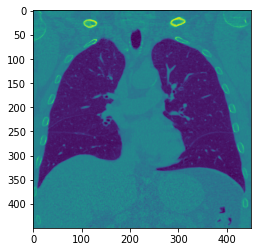

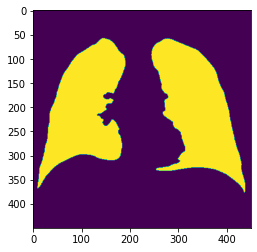

In [4]:
import matplotlib.pyplot as plt
import numpy as np
#matplotlib inline 
folder = 'D:/MIA/handin2/data1/'

imageArray = np.load(folder + 'lungCTSlice.npy')
maskArray = np.load(folder + 'lungMask.npy')
plt.figure(1)
plt.imshow(imageArray)
plt.figure(2)
plt.imshow(maskArray)



## Thresholding

Exercise 1.1. Please implement thresholding function and test it on -500, -300, and -150 threshold levels. Please visualize these results of thersholding in the similar way the lungMask.npy is visualized at the description of the assignment.

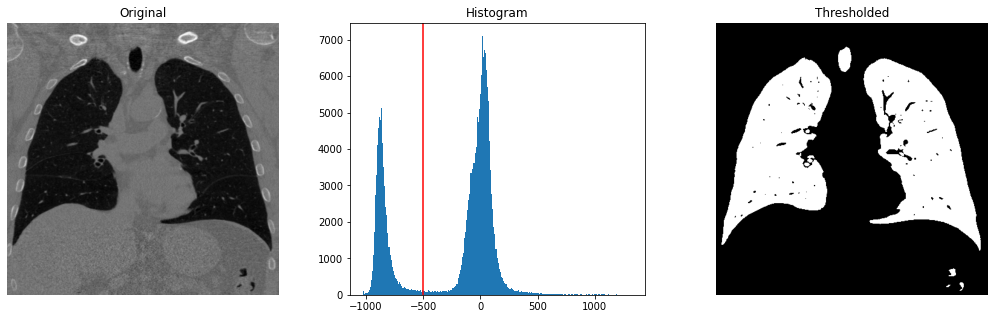

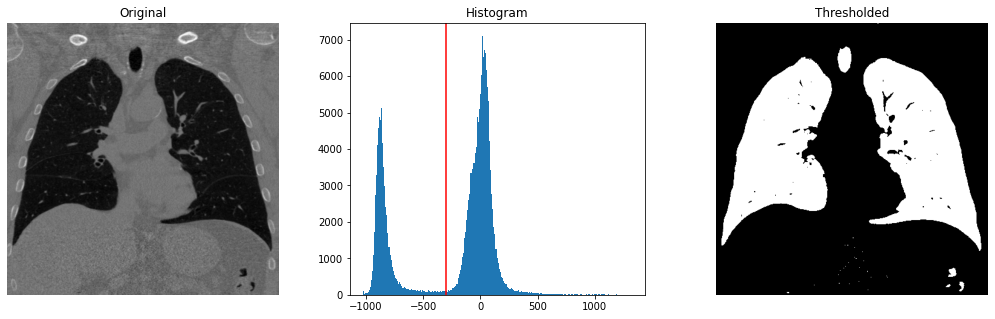

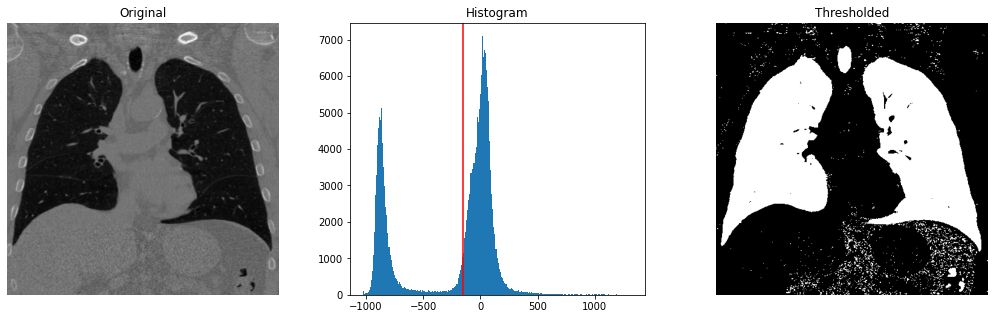

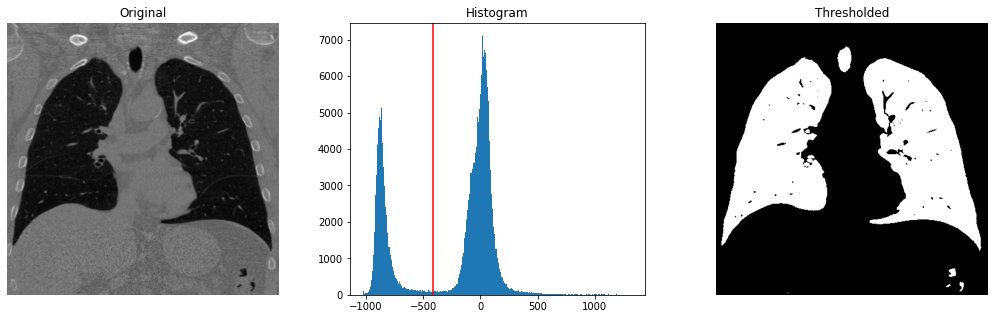

In [9]:
# implement a function for thresholding 2D arrays
from skimage import data
from skimage.filters import threshold_otsu

def threshold_image(threshold, img):
    #thresh = threshold_otsu(img)
    binary = img < threshold
    return binary


# implement a function for visualization of thresholding results

def show_threshold(t, img, method=None):
    if method == None:
        b = threshold_image(t, img)
    elif method == "otsu":
        b = threshold_otsu(img)
        t = b
        b = img <= b  

    fig, axes = plt.subplots(ncols=3, figsize=(18,5))
    ax = axes.ravel()

    ax[0] = plt.subplot(1, 3, 1)
    ax[1] = plt.subplot(1, 3, 2)
    ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title('Original')
    ax[0].axis('off')

    ax[1].hist(img.ravel(), bins=256)
    ax[1].set_title('Histogram')
    ax[1].axvline(t, color='r')

    ax[2].imshow(b, cmap=plt.cm.gray) 
    ax[2].set_title('Thresholded')
    ax[2].axis('off')
    plt.show()

show_threshold(-500, imageArray)
show_threshold(-300, imageArray)
show_threshold(-150, imageArray)
show_threshold(0, imageArray, "otsu")


# Dice coefficient

Dice coefficient is useful to evaluate the results of image segmentation. The Dice coefficient counts pixels that are classified as the object in both manual and automated segmentation (true positives TP), as background in manual segmentation and as the object in automated segmentation (false positive FP), as the object in manual segmentation and as background in automated segmentation (false negative FN) and as background in both manual and automated segmentation (true negative TN)

The Dice coefficient is computed as:
$$DSC = \frac{2*TP}{2*TP + FP + FN} $$

Exercise 1.2. Please implement the Dice coefficient, and test it on the results of lung CT thresholding. Find the optimal threshold by comparing the Dice coefficients for different threshold  values in the interval [-1000; 0]

Exercise 1.3. Please write your reflection on why TN is not used in the Dice coefficient definition?

(-475, 0.9778319162323938)


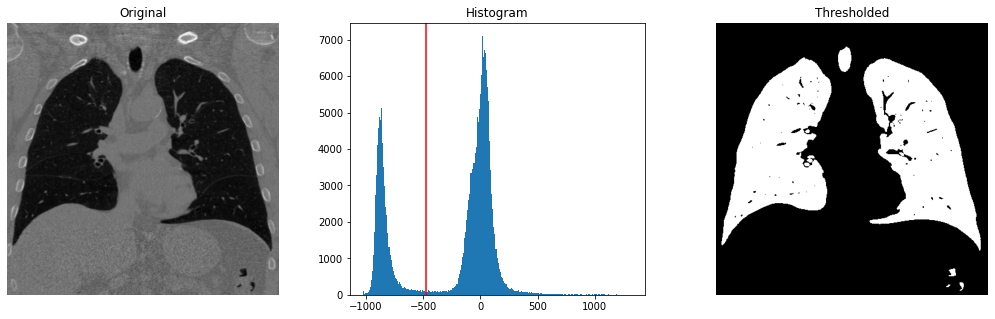

In [12]:
# implement the Dice coefficient calculation

def dsc(seg, gt):
    
    seg = np.array(seg, dtype=bool).flatten().flatten()
    gt = np.array(gt, dtype=bool).flatten().flatten()

    tp = np.sum(seg[gt==True])
    fp = np.sum(seg[gt==False])
    fn = np.sum(gt[seg==False])

    return (tp*2.) / (2.*tp+fp+fn)

# implement a function for selecting an optimal threshold using the Dice coefficient calculation function

def best_thresh(ran,mask,org):
    dsc_score = 0
    thresh = None
    for i in range(ran[0], ran[1]+1):
        temp = dsc(threshold_image(i, org), mask)
        if dsc_score < temp:
            dsc_score = temp
            thresh = i
    return (thresh, dsc_score)

res = best_thresh((-1000, 0), maskArray, imageArray)
print(res)
show_threshold(res[0], imageArray)





# Exercise 2

# Connected Component Decomposition

Thresholding operation does not only mark lung fields but also non-lung image pixels with low intensity. The aim of this subtask is to implement a simple algorithm for the extraction of lung fields form the thresholded image. The lung fields represent the largest dark connected objects. Let’s try to use this information.

Exercise 2.1. Implement the connected component decomposition algorithm. Apply it on the 2D masks representing the optimally thresholded lung CT image. Extract the largest component and discard all other components. Form the lung field mask the correspond to the largest connected components. 

Exercise 2.2. Plot the connected components and the largest connected components.Compute and print the Dice coefficient of the improved lung segmentation.


In [11]:
# implement a function for connected component decomposition on 2D arrays

from email.mime import image
from skimage.measure import label

def label_lungs(img):
    air_seg = label(img)
    largest_connected_air = air_seg == np.argmax(np.bincount(air_seg.flat)[1:]) + 1
    largest_connected_air += air_seg == np.argmax(np.bincount(air_seg.flat)[2:]) + 1
    return largest_connected_air


# Exercise 3

# Morthological operation

Lungs on CT are not only air but also vasculature. Thresholding did not capture lung vasculature and lung segmentation is therefore incomplete. Let’s try to apply morphological operations to include vasculature into the lung segmentation.



Exercise 3.1. Implement morphological dilation and erosion operations. Perform in a consecutive order one dilation and one erosion on the result of the previous subtask. Visualize the obtained result. Find an optimal sequence of dilations and erosions that can maximally improve the Dice coefficient of the lung segmentation.

()
(0,)
(1,)
(0, 0)
(0, 1)
(1, 1)
(0, 0, 0)
(0, 0, 1)
(0, 1, 1)
(1, 1, 1)
(0, 0, 0, 0)
(0, 0, 0, 1)
(0, 0, 1, 1)
(0, 1, 1, 1)
(1, 1, 1, 1)
(0, 0, 0, 0, 0)
(0, 0, 0, 0, 1)
(0, 0, 0, 1, 1)
(0, 0, 1, 1, 1)
(0, 1, 1, 1, 1)
(1, 1, 1, 1, 1)
(1, 1, 1)
x 0.9087331219087946, y 0.9563393855286998


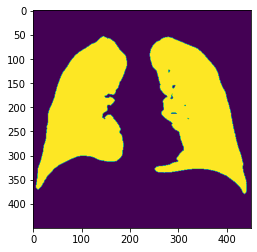

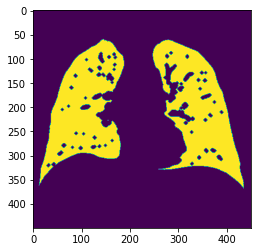

In [13]:
# implement a function for morphological dilation and erosion on 2D arrays

from skimage.morphology import erosion, dilation

cross = np.array([[0,1,0],
                  [1,1,1],
                  [0,1,0]])

def de(type, amount, img , con):
    for i in range(amount):
        if type == "dilation":
            img = dilation(img, con)
        elif type == "erosion":
            img = erosion(img, con)
    return img


# visualize the result of connected component decomposition using lung CT thresholded 
# with the optimal threshold from the previous subtask

opt_thresh = best_thresh((-1000, 0), maskArray, imageArray)[0]
t_image = threshold_image(opt_thresh, imageArray)
ss = label_lungs(t_image)
ss = de("dilation", 5, ss, cross)
ss = de("erosion", 1, ss, cross)

#plt.imshow(ss)
#plt.show()

# implement a function that finds an optimal sequence of dilation and erosion operations 
# (restrict your search to max 5 dilation and 5 erosions).

import itertools

seqArr = []
set_s = [0,1]
for L in range(6):
    for subset in itertools.combinations_with_replacement(set_s, L):
        seqArr.append(subset)
        #print(subset)

def opt_de(t_img, gt, t):
    labled = label_lungs(t_img)
    dsc_score = 0
    d_e = ()
    for i, var in enumerate(seqArr):
        print(var)
        for j, var2 in enumerate(var):
            if var2 == 0:
                labled = de("dilation",1,labled, cross)
            elif var2 == 1:
                labled = de("erosion",1,labled, cross)
        temp = dsc(labled, gt)
        if temp > dsc_score:
            dsc_score = temp
            d_e = var
    return d_e

something = opt_de(t_image, maskArray, cross)
print (something)

label_shit = label_lungs(t_image)

x = de("erosion", 3, label_shit, cross)
y = de("dilation", 3, label_shit, cross)

print(f'x {dsc(x, maskArray)}, y {dsc(y, maskArray)}')

plt.imshow(y)
plt.show()
plt.imshow(x)
plt.show()




# implement visualization of the optimal sequence morphological operation sequence and print the Dice coefficient